In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from slime.city import City
import pandas as pd

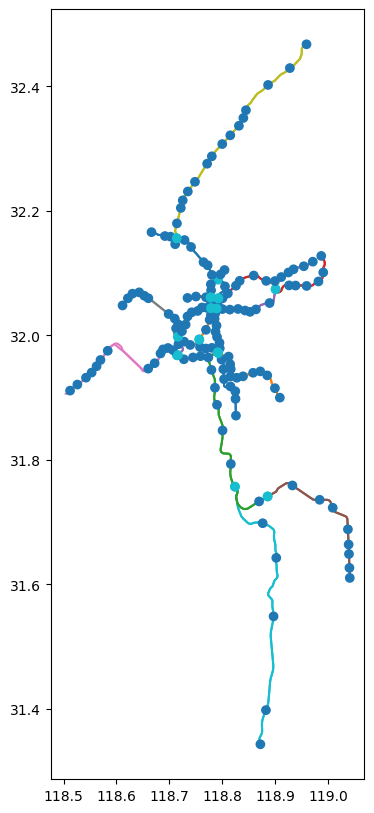

In [2]:
stations = gpd.read_file('database/nanjing_nodes.geojson')
routes = gpd.read_file('database/nanjing_edges.geojson')
# drop irrelevant columns and null value
stations = stations.drop(['name', 'marker-symbol', 'marker-size'], axis=1)
routes = routes.drop(['name', 'ref'], axis=1)
stations = stations[~stations['marker-color'].isnull()].reset_index().drop(['index'], axis=1)
# gpd.options.display_precision = 4
fig, ax = plt.subplots(figsize=(10, 10))
stations.plot(ax=ax, column=stations['marker-color'], zorder=2)
routes.plot(ax=ax, column='stroke', zorder=1)
plt.show()

In [3]:
# preprocess node attribute
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y
stations['value'] = np.where(stations['marker-color']=='#ff2600', 10, 5)
min_x = min(stations['lon'])
min_y = min(stations['lat'])
stations['x'] = stations.lon.apply(lambda x: int((x - min_x) * (10**3))+ 30)
stations['y'] = stations.lat.apply(lambda y: int((y - min_y) * (10**3))+ 30)
stations['type'] = 'False'
stations.loc[stations['x'] == max(stations['x']), 'type'] = 'right'
stations.loc[stations['x'] == min(stations['x']), 'type'] = 'left'
stations.loc[stations['y'] == max(stations['y']), 'type'] = 'up'
stations.loc[stations['y'] == min(stations['y']), 'type'] = 'down'
stations = pd.DataFrame(stations.drop(['geometry'], axis=1))


In [4]:
routes.head()

,stroke,geometry
0,#f1bc1a,"LINESTRING (118.82147 31.75946, 118.82281 31.7..."
1,#f1bc1a,"LINESTRING (118.87229 31.34309, 118.87190 31.3..."
2,#ca8687,"LINESTRING (119.04148 31.61031, 119.04083 31.6..."
3,#ca8687,"LINESTRING (118.88598 31.74120, 118.90000 31.7..."
4,#da60cd,"LINESTRING (118.50250 31.90719, 118.50285 31.9..."


In [5]:
stations.head()

,marker-color,lon,lat,value,x,y,type
0,#797979,118.863858,32.041670,5,381,728,False
1,#797979,118.779027,32.052965,5,296,739,False
2,#797979,118.982163,32.086573,5,500,773,False
3,#797979,118.542290,31.931998,5,60,618,False
4,#ff2600,118.789430,32.044122,10,307,731,False


In [6]:
# fig = plt.figure(figsize=(20, 10))
# sns.scatterplot(stations, x='x', y='y', hue='value')

In [7]:
city = City(city_shape=(max(stations.x) + 50, max(stations.y) + 50), foods=stations, mould_shape=(50, 50), init_mould_coverage=1, decay=0.02)

In [8]:
# city.draw_foods()

NetworkXNoPath: No path between 154 and 122.

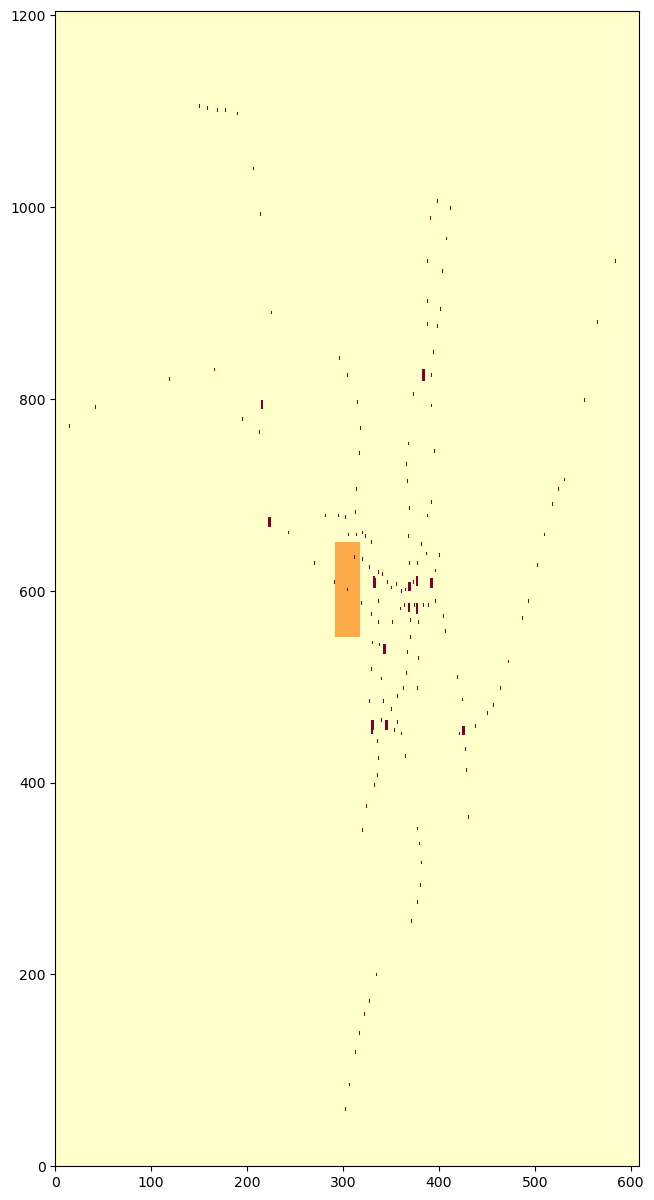

In [9]:
city.animate(frames=100, interval=100, filename="output/test2.gif")
plt.show()